# Build simple AML pipeline end-to-end

## 0. Importing required libraries

In [248]:
import pandas as pd
import numpy as np
import GPy
import GPyOpt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from GPyOpt.methods import BayesianOptimization

## 1. Reading provided data

In [29]:
df = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv')
pandas.set_option('display.max_columns', None)
df.head()

,loss,Exposure,Rating_Class,Sub_Rating_Class,Renewal_class,Sub_Renewal_Class,Property_size,Residents,Commercial,Norm_fire_risk,Norm_monthly_rent,Loan_mortgage,No_claim_Years,Previous_claims,Norm_area_m,Premium_remain,Premium_renew,Renewal_Type,crime_property_type,crime_residents,crime_area,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO,ISO_cat,ISO_desc
0,0.07,3.0,H1,NaN,NaN,NaN,3.0,4.0,NaN,4.314082,758.287544,2.673639,2.251423,0.0,10.0,NaN,0.000000,B,1.209807,1.064398,1.066522,0.939346,1.708534,0.808015,1.040819,1.171366,0.284447,0.313157,5,ISO 5 - Modified or Semi Fire Resistive (MFR o...,which and floors. greater roof _—– modified an...
1,0.13,NaN,M1,NaN,NaN,NaN,6.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,NaN,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006305,0.889677,6,ISO 6 - Fire Resistive (FR),bearing are walls deck/cover precast and/or co...
2,0.02,NaN,M1,NaN,NaN,NaN,4.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,8.0,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019372,0.276507,1,ISO 1 Frame (combustible walls or roof),*BUR 1B and covers the *Single-ply wood/hardip...
3,0.13,NaN,M1,NaN,NaN,NaN,2.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,12.0,NaN,86.666667,B,2.304699,1.912726,1.463283,1.632539,1.205554,1.999838,1.665336,1.779279,0.085413,0.124679,1,ISO 1 Frame (combustible walls or roof),"frame anchorage are wood. *Less Habitational, ..."
4,0.04,3.0,H1,NaN,NaN,NaN,4.0,3.0,NaN,4.314082,716.709146,2.711775,2.408759,0.0,NaN,100.0,0.000000,B,0.669145,0.430252,0.345801,0.638615,0.567431,0.751454,0.585363,0.729587,5.570830,0.703054,6,ISO 6 - Fire Resistive (FR),is roof deck structural on roof - poured occup...


## 2. Exploratory data analysis

Describing numerical features

In [8]:
df.describe()

,loss,Exposure,Property_size,Residents,Norm_fire_risk,Norm_monthly_rent,Loan_mortgage,No_claim_Years,Previous_claims,Norm_area_m,...,crime_residents,crime_area,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO
count,1217.000000,210.000000,1216.000000,1212.000000,1217.000000,1217.000000,196.000000,1217.000000,353.000000,1047.000000,...,910.000000,923.000000,916.000000,922.000000,923.000000,903.000000,923.000000,1211.000000,1213.000000,1217.000000
mean,0.080477,2.809524,3.820724,2.514026,4.040762,1852.694145,3.286935,1.010640,0.320084,34.265521,...,0.958211,0.989317,0.954384,1.044832,0.982719,0.962596,0.992618,1.125001,0.918192,2.889071
std,0.050425,0.726731,1.598589,1.318972,0.232445,1678.089181,0.243295,0.769526,0.500960,25.261731,...,0.403047,0.407156,0.238484,0.523383,0.490376,0.254882,0.358018,1.918566,1.094440,1.598731
min,0.010000,1.000000,1.000000,1.000000,3.776480,500.000000,2.673639,0.000000,0.000000,0.000000,...,0.360578,0.065520,0.472193,0.154595,0.000000,0.522494,0.175763,0.000000,0.000000,1.000000
25%,0.040000,2.000000,3.000000,1.000000,3.898949,783.693499,3.144307,0.000000,0.000000,16.000000,...,0.625186,0.687961,0.739102,0.572656,0.686813,0.739831,0.767780,0.091752,0.273559,2.000000
50%,0.070000,3.000000,3.500000,2.000000,3.898949,1232.882801,3.339025,1.048147,0.000000,30.000000,...,0.903848,0.924562,0.942690,1.019386,0.989819,0.924495,0.974872,0.392954,0.550059,3.000000
75%,0.100000,3.000000,5.000000,4.000000,4.171214,2248.569323,3.474623,1.665109,0.832555,47.000000,...,1.210431,1.190282,1.130489,1.322650,1.191823,1.110430,1.193020,1.059832,1.204226,4.000000
max,0.200000,5.000000,8.000000,6.000000,5.123351,13296.240070,3.714656,2.639501,1.893018,208.000000,...,2.970605,4.145968,1.926021,2.391149,4.322882,2.043525,2.641966,8.548033,9.098934,6.000000


Data types of provided data

In [7]:
df.dtypes

loss                     float64
Exposure                 float64
Rating_Class              object
Sub_Rating_Class          object
Renewal_class             object
Sub_Renewal_Class         object
Property_size            float64
Residents                float64
Commercial                object
Norm_fire_risk           float64
Norm_monthly_rent        float64
Loan_mortgage            float64
No_claim_Years           float64
Previous_claims          float64
Norm_area_m              float64
Premium_remain           float64
Premium_renew            float64
Renewal_Type              object
crime_property_type      float64
crime_residents          float64
crime_area               float64
crime_arson              float64
crime_burglary           float64
crime_neighbour_watch    float64
crime_community          float64
crime_risk               float64
Geographical_risk        float64
Weather_risk             float64
ISO                        int64
ISO_cat                   object
ISO_desc  

## 3. Feature enginering

Adding new features:
- "Residents_per_size" = "Residents" / "Property_size"
- "Overall_risk" = ("Norm_fire_risk" + "crime_risk" + "Geographical_risk" + "Weather_risk")/4

In [30]:
df['Residents_per_size'] = df.Residents/df.Property_size
# copy df to keep original one unchanged, but impute a new one for overall risk calcualtion
# treat NaN as 0 for this calculation
temp_df = df.copy()
temp_df.Norm_fire_risk.fillna(0, inplace=True)
temp_df.crime_risk.fillna(0, inplace=True)
temp_df.Geographical_risk.fillna(0, inplace=True)
temp_df.Weather_risk.fillna(0, inplace=True)
df['Overall_risk'] = ( temp_df.Norm_fire_risk + temp_df.crime_risk + temp_df.Geographical_risk + temp_df.Weather_risk)/4

pandas.set_option('display.max_columns', None)
df.head()

,loss,Exposure,Rating_Class,Sub_Rating_Class,Renewal_class,Sub_Renewal_Class,Property_size,Residents,Commercial,Norm_fire_risk,Norm_monthly_rent,Loan_mortgage,No_claim_Years,Previous_claims,Norm_area_m,Premium_remain,Premium_renew,Renewal_Type,crime_property_type,crime_residents,crime_area,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO,ISO_cat,ISO_desc,Residents_per_size,Overall_risk
0,0.07,3.0,H1,NaN,NaN,NaN,3.0,4.0,NaN,4.314082,758.287544,2.673639,2.251423,0.0,10.0,NaN,0.000000,B,1.209807,1.064398,1.066522,0.939346,1.708534,0.808015,1.040819,1.171366,0.284447,0.313157,5,ISO 5 - Modified or Semi Fire Resistive (MFR o...,which and floors. greater roof _—– modified an...,1.333333,1.520763
1,0.13,NaN,M1,NaN,NaN,NaN,6.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,NaN,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006305,0.889677,6,ISO 6 - Fire Resistive (FR),bearing are walls deck/cover precast and/or co...,0.166667,1.266799
2,0.02,NaN,M1,NaN,NaN,NaN,4.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,8.0,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019372,0.276507,1,ISO 1 Frame (combustible walls or roof),*BUR 1B and covers the *Single-ply wood/hardip...,0.250000,1.116773
3,0.13,NaN,M1,NaN,NaN,NaN,2.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,12.0,NaN,86.666667,B,2.304699,1.912726,1.463283,1.632539,1.205554,1.999838,1.665336,1.779279,0.085413,0.124679,1,ISO 1 Frame (combustible walls or roof),"frame anchorage are wood. *Less Habitational, ...",0.500000,1.540146
4,0.04,3.0,H1,NaN,NaN,NaN,4.0,3.0,NaN,4.314082,716.709146,2.711775,2.408759,0.0,NaN,100.0,0.000000,B,0.669145,0.430252,0.345801,0.638615,0.567431,0.751454,0.585363,0.729587,5.570830,0.703054,6,ISO 6 - Fire Resistive (FR),is roof deck structural on roof - poured occup...,0.750000,2.829388


## 4. CV partitioning

In [42]:
y = df.loss.copy()
X = df.copy().drop('loss', axis=1)
# splitting data to test and train as 15% vs. 85%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=7)

## 5. Build pipelines

I am using ElasticNet instead of Linear Regression t enable hyperparameters optimization. Usual Linear Regression simply has no hyperparameters to tune.

In [222]:
# defining numeric features
numeric_features = X_train.select_dtypes(include=np.number).columns

# defining categorical features
categorical_features = X_train.select_dtypes(include=np.object).columns.drop('ISO_desc')

# defining text features
text_features = 'ISO_desc'

# defining pipeline for numeric data
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('scaler', StandardScaler())
])

# defining pipeline for categorical data
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# defining pipeline for text data
text_pipeline = Pipeline(steps=[
    ('tf_idf', TfidfVectorizer(stop_words='english'))
])

# defining preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features)
    ]
)

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('EN', ElasticNet(random_state=7))
])

#fit the model
est.fit(X_train, y_train)

print("Model MAE: %.7f" % mean_absolute_error(y_test, est.predict(X_test)))

Model MAE: 0.0403518


## 6. Optimize model hyperparameters

### Optimization using Grid Search

In [122]:
# defining dictionary with parameters to serach through
params = dict(EN__l1_ratio = np.arange(0.1, 1, 0.05), EN__alpha = np.arange(0, 2, 0.1))
# define grid search
gs = GridSearchCV(estimator=est, param_grid=params, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3, cv=5)
# execute grid search
gs.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

Printing best parameters, estimator and its score

In [123]:
gs.best_params_

{'EN__alpha': 0.1, 'EN__l1_ratio': 0.1}

In [124]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                              

In [223]:
print("Optimized model MAE: %.7f" % (-1*gs.best_score_)) 

Optimized model MAE: 0.0400362


### Optimization using Random Search

In [224]:
# defining dictionary with parameters to serach through
params_dist = dict(EN__l1_ratio = uniform(loc=0, scale=1), EN__alpha = uniform(loc=0, scale=2))
# define Random Search
rs = RandomizedSearchCV(estimator=est, param_distributions=params_dist, scoring='neg_mean_absolute_error', n_iter=1000, n_jobs=-1, verbose=3, random_state=7, cv=5)
#execute Random Search
rs.fit(X_train,y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

Printing best parameters, estimator and its score

In [225]:
rs.best_params_

{'EN__alpha': 0.012753656202565189, 'EN__l1_ratio': 0.028049402896189624}

In [226]:
rs.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                              

In [228]:
print("Optimized model MAE: %.7f" % (-1*rs.best_score_)) 

Optimized model MAE: 0.0384587


### Optimization using Bayesian Optimization

In [231]:
# defining numeric features
numeric_features = X_train.select_dtypes(include=np.number).columns

# defining categorical features
categorical_features = X_train.select_dtypes(include=np.object).columns.drop('ISO_desc')

# defining text features
text_features = 'ISO_desc'

# defining pipeline for numeric data
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('scaler', StandardScaler())
])

# defining pipeline for categorical data
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# defining pipeline for text data
text_pipeline = Pipeline(steps=[
    ('tf_idf', TfidfVectorizer(stop_words='english'))
])

# defining preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features)
    ]
)

# defining single function for our regression in order to run Bayesian optimization
def ENR(args):
    
    # Append estimator to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    est = Pipeline(steps=[('preprocessor', preprocessor),
                          ('EN', ElasticNet(l1_ratio=float(args[0][0]), alpha=float(args[0][1]), random_state=7))
    ])

    #fit the model
    est.fit(X_train, y_train)
    #return model score as single value
    score = cross_val_score(est, X_test, y_test, scoring='neg_mean_absolute_error').mean()
    
#     ENR = RandomForestRegressor(max_depth=int(args[0][0]), n_estimators = int(args[0][1]), max_features = int(args[0][2]), random_state=7)
#     rfreg.fit(X, y)
#     score = cross_val_score(rfreg, X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [237]:
# define parameters distribution to search through
domains = [{'name':'l1_ratio', 'type':'continuous', 'domain': (0,1)},
      {'name': 'alpha', 'type': 'continuous', 'domain': (0,2)}
          ]
# define Bayesian optimizer
optimizer = BayesianOptimization(f=ENR, model_type='GP', acquisition_type='EI', domain=domains, maximize=True)
# execute optimization
optimizer.run_optimization(max_iter=100, verbosity=True)

num acquisition: 1, time elapsed: 0.44s
num acquisition: 2, time elapsed: 0.87s
num acquisition: 3, time elapsed: 1.27s
num acquisition: 4, time elapsed: 1.68s
num acquisition: 5, time elapsed: 2.17s
num acquisition: 6, time elapsed: 2.85s
num acquisition: 7, time elapsed: 3.52s
num acquisition: 8, time elapsed: 4.15s
num acquisition: 9, time elapsed: 4.77s
num acquisition: 10, time elapsed: 5.42s
num acquisition: 11, time elapsed: 6.01s
num acquisition: 12, time elapsed: 6.41s
num acquisition: 13, time elapsed: 6.85s
num acquisition: 14, time elapsed: 7.30s
num acquisition: 15, time elapsed: 7.71s
num acquisition: 16, time elapsed: 8.34s
num acquisition: 17, time elapsed: 9.05s
num acquisition: 18, time elapsed: 9.65s
num acquisition: 19, time elapsed: 10.29s
num acquisition: 20, time elapsed: 10.74s
num acquisition: 21, time elapsed: 11.17s
num acquisition: 22, time elapsed: 11.85s
num acquisition: 23, time elapsed: 12.51s
num acquisition: 24, time elapsed: 13.15s
num acquisition: 25

Plot and print results of optimization

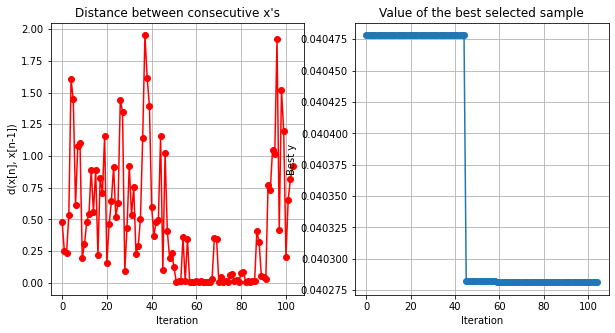

In [238]:
optimizer.plot_convergence()

In [239]:
print("Optimal parameters are l1_ratio = %.7f and alpha = %.7f." % (optimizer.x_opt[0], optimizer.x_opt[1]))

print("Optimal function value is %.5f" % optimizer.fx_opt)

Optimal parameters are l1_ratio = 0.0634455 and alpha = 0.0894890.
Optimal function value is 0.04028


## 7. Report results

Here I provide summary of three optimized models

In [246]:
print("Best parameters found by Grid Search:", gs.best_params_)
print("MAE of model optimized by Grid Search: %.7f" % (-1*gs.best_score_)) 

print("Best parameters found by Random Search:", rs.best_params_)
print("MAE of model optimized by Random Search: %.7f" % (-1*rs.best_score_)) 

print("Optimal parameters are l1_ratio = %.7f and alpha = %.7f." % (optimizer.x_opt[0], optimizer.x_opt[1]))
print("Optimal function value is %.5f" % optimizer.fx_opt)

Best parameters found by Grid Search: {'EN__alpha': 0.1, 'EN__l1_ratio': 0.1}
MAE of model optimized by Grid Search: 0.0400362
Best parameters found by Random Search: {'EN__alpha': 0.012753656202565189, 'EN__l1_ratio': 0.028049402896189624}
MAE of model optimized by Random Search: 0.0384587
Optimal parameters are l1_ratio = 0.0634455 and alpha = 0.0894890.
Optimal function value is 0.04028


**Conclusion:** Best optimal parameters were found by Random Search. Model optimized with Random Search has smallest error within all three optimized models. Grid Search took second place with regards of optimized model score. And, what was a surprise for me, Bayesian Optimization provides worse result and took only third place.

## Bonus part

### Random Forest Regression

Repeatin steps 5-7 for Random Forest Regressor.

In [256]:
# defining numeric features
numeric_features = X_train.select_dtypes(include=np.number).columns

# defining categorical features
categorical_features = X_train.select_dtypes(include=np.object).columns.drop('ISO_desc')

# defining text features
text_features = 'ISO_desc'

# defining pipeline for numeric data - removing scaler for Random Forest since it is not required
numeric_pipeline_rfr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# defining pipeline for categorical data 
categorical_pipeline_rfr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# defining pipeline for text data
text_pipeline_rfr = Pipeline(steps=[
    ('tf_idf', TfidfVectorizer(stop_words='english'))
])

# defining preprocessor
preprocessor_rfr = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_rfr, numeric_features),
        ('cat', categorical_pipeline_rfr, categorical_features),
        ('text', text_pipeline_rfr, text_features)
    ]
)

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est_rfr = Pipeline(steps=[('preprocessor', preprocessor_rfr),
                      ('RFR', RandomForestRegressor(random_state=7, criterion='mae'))
])

#fit the model
est_rfr.fit(X_train, y_train)

print("Random Forest Regressor model MAE: %.7f" % mean_absolute_error(y_test, est_rfr.predict(X_test)))

Random Forest Regressor model MAE: 0.0358858


In [273]:
# Execute Grid Search for Random Forest 

# defining dictionary with parameters to search through
params_rfr = dict(RFR__max_depth = np.arange(1, 22, 5), RFR__n_estimators = np.arange(100, 201, 20), 
                  RFR__max_features = np.arange(0.1, 1.05, 0.1))
# define grid search
gs_rfr = GridSearchCV(estimator=est_rfr, param_grid=params_rfr, scoring='neg_mean_absolute_error', 
                      n_jobs=-1, verbose=3, cv=5)
# execute grid search
gs_rfr.fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min


KeyboardInterrupt: 

In [260]:
print("Best parameters found by Grid Search for Random Forest:", gs_rfr.best_params_)
print("MAE of optimized Random Forest by Grid Search: %.7f" % (-1*gs_rfr.best_score_)) 

# print("Best parameters found by Random Search:", rs.best_params_)
# print("MAE of model optimized by Random Search: %.7f" % (-1*rs.best_score_)) 

# print("Optimal parameters are l1_ratio = %.7f and alpha = %.7f." % (optimizer.x_opt[0], optimizer.x_opt[1]))
# print("Optimal function value is %.5f" % optimizer.fx_opt)

Best parameters found by Grid Search for Random Forest: {'RFR__max_depth': 11, 'RFR__max_features': 29, 'RFR__n_estimators': 150}
MAE of optimized Random Forest by Grid Search: 0.0367291


In [272]:
np.arange(0.1, 1.05, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [219]:
uniform.rvs(loc=0, scale=1)

1.579654895317987